# Advanced Lane Finding

In [1]:
# Library import
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import pickle
import glob
from moviepy.editor import VideoFileClip
from IPython.display import HTML

%matplotlib inline

## Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.

working on ./camera_cal/calibration10.jpg


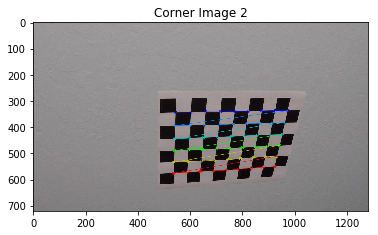

working on ./camera_cal/calibration11.jpg


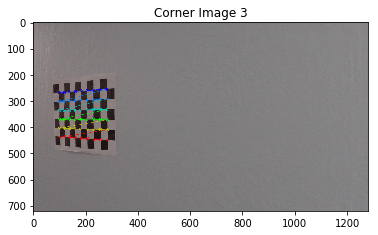

working on ./camera_cal/calibration12.jpg


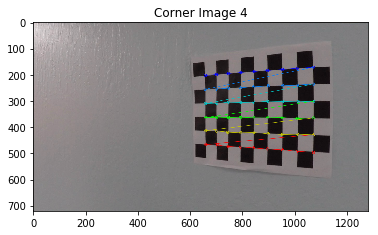

working on ./camera_cal/calibration13.jpg


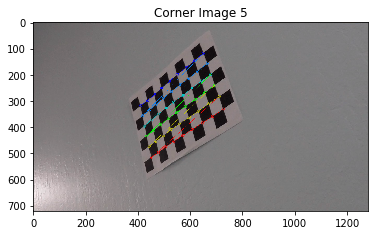

working on ./camera_cal/calibration14.jpg


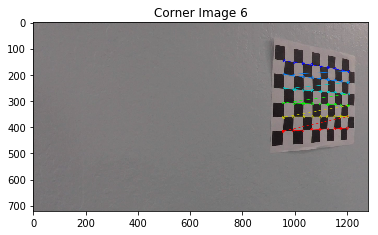

working on ./camera_cal/calibration15.jpg


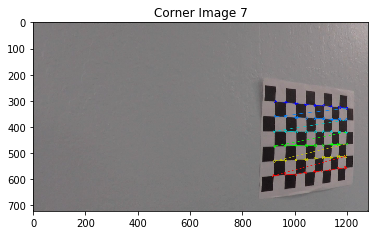

working on ./camera_cal/calibration16.jpg


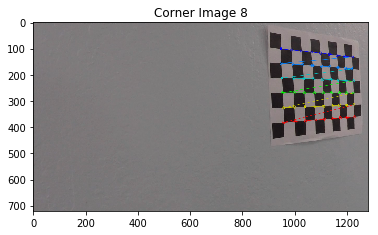

working on ./camera_cal/calibration17.jpg


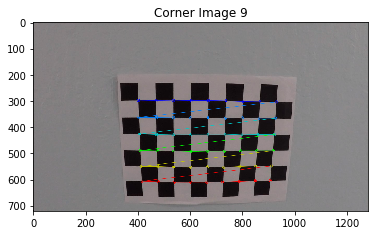

working on ./camera_cal/calibration18.jpg


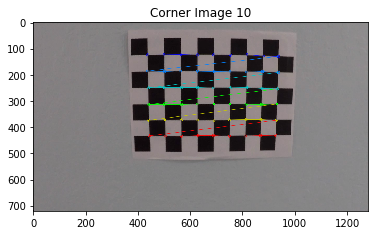

working on ./camera_cal/calibration19.jpg


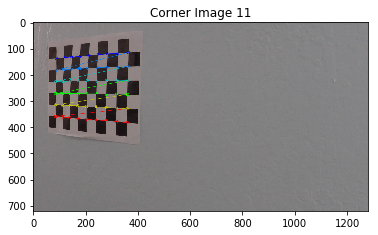

working on ./camera_cal/calibration2.jpg


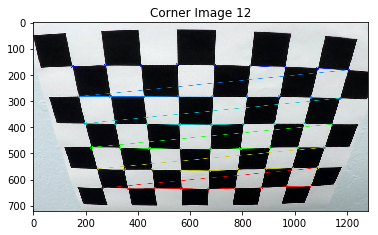

working on ./camera_cal/calibration20.jpg


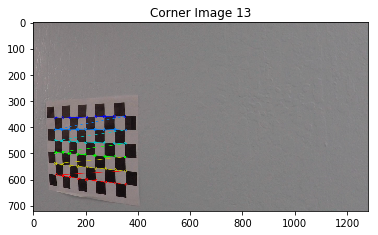

working on ./camera_cal/calibration3.jpg


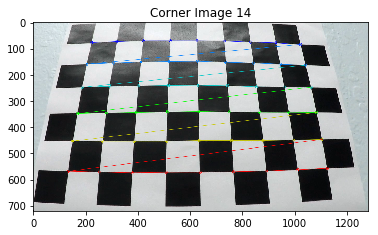

working on ./camera_cal/calibration6.jpg


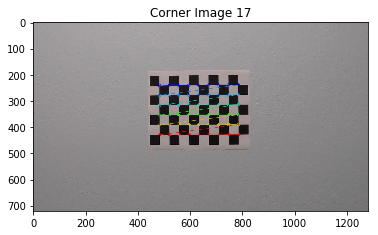

working on ./camera_cal/calibration7.jpg


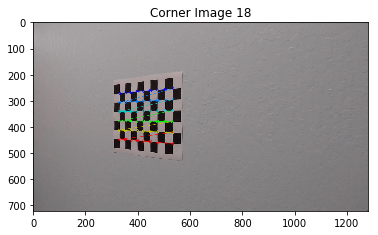

working on ./camera_cal/calibration8.jpg


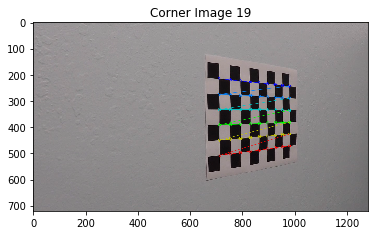

working on ./camera_cal/calibration9.jpg


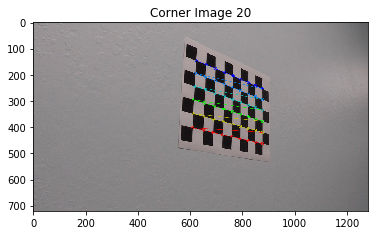

Finished


In [2]:
# Makes a list of calibration images
images = glob.glob('./camera_cal/calibration*.jpg')

# Number of inner corners derived from picture
nx = 9 # number of inside corners in x
ny = 6 # number of inside corners in y

# Arrays to store the object and image points from all the images
objpoints = [] # 3dpoints in real world space
imgpoints = [] # 2d points in image plane

# Prepares object points (0,0,0) (1,0,0) (2,0,0) ...  (9,5,0)
objp = np.zeros((ny*nx,3), np.float32) 
objp[:,:2] = np.mgrid[0:nx, 0:ny].T.reshape(-1,2)

# Steps through the image list and search for corners
for idx, fname in enumerate(images):
    # Fetch the image
    img = cv2.imread(fname)
    
    # Grayscaling
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # Finds the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (nx, ny), None)

    # If found, add object points, image points
    if ret == True:
        print('working on', fname)
        objpoints.append(objp)
        imgpoints.append(corners)
    
        # Draw and display the corners
        cv2.drawChessboardCorners(img, (nx, ny), corners, ret)
        write_name = './camera_cal/corners_found' + str(idx + 1) + '.jpg'
        cv2.imwrite(write_name, img)
        cv2.waitKey(500)
        
        plt.imshow(img)
        plt.title('Corner Image ' + str(idx + 1))
        plt.show()
    
# Loads image for references
img = cv2.imread('./camera_cal/calibration1.jpg')
img_size = (img.shape[1], img.shape[0])

# Calibrats parameters: calibration matrix (mtx) and dist(ortion coefficients)
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img_size, None, None)

# Saves the camera calibration result
dist_pickle = {}
dist_pickle['mtx'] = mtx
dist_pickle['dist'] = dist
pickle.dump( dist_pickle, open('./camera_cal/calibration_pickle.p', 'wb'))
print('Finished')

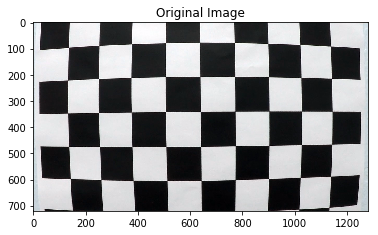

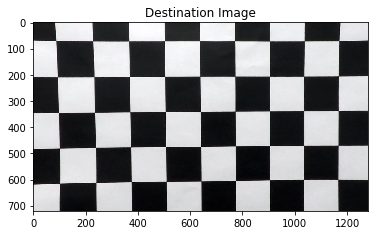

In [3]:
# Loads image
img = cv2.imread('./camera_cal/calibration1.jpg')
plt.title('Original Image')
plt.imshow(img)
plt.show()

# Undistorts test image
dst = cv2.undistort(img, mtx, dist, None, mtx)
plt.imshow(dst)
plt.title('Destination Image')
plt.show()

## Apply a distortion correction to raw images.

Finished


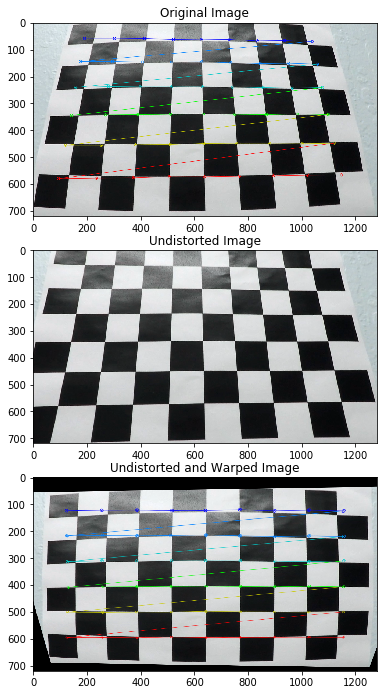

In [4]:
# Reads in the saved camera matrix and distortion coefficients
dist_pickle = pickle.load( open( './camera_cal/calibration_pickle.p', 'rb' ) )
mtx = dist_pickle["mtx"]
dist = dist_pickle["dist"]

# Reads in an image
img = cv2.imread('./camera_cal/calibration3.jpg')
nx = 9 # the number of inside corners in x
ny = 6 # the number of inside corners in y
                                
def corners_unwarp(img, nx, ny, mtx, dist):
                                
    # Undistorts image using mtx and dist
    undist = cv2.undistort(img, mtx, dist, None, mtx)
                                
    # Converts image to grayscale
    gray = cv2.cvtColor(undist,cv2.COLOR_BGR2GRAY)
                                
    # Finds the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (nx, ny),None)
                                
    if ret == True:
        # Draws corners
        cv2.drawChessboardCorners(img, (nx, ny), corners, ret)
        
        # Defines four source points  in src (source)
        src = np.float32([
                        corners[0], 
                        corners[nx-1], 
                        corners[-1], 
                        corners [-nx]])
                                
        # Defines four destination points in dst (destination)
        offset = 125
        img_size = (gray.shape[1], gray.shape[0])
        
        dst = np.float32([
                        [offset, offset],
                        [img_size[0]-offset, offset],
                        [img_size[0]-offset, img_size[1]-offset],
                        [offset, img_size[1]-offset]
                         ])
        
        # Calculates transform matrix M
        M = cv2.getPerspectiveTransform(src, dst)
                    
        # Warps image to a top-down view
        warped = cv2.warpPerspective(img, M, img_size, flags=cv2.INTER_LINEAR)
        
        return warped, M
    

# Plots the results
undist = cv2.undistort(img, mtx, dist, None, mtx)
top_down, perspective_M = corners_unwarp(img, nx, ny, mtx, dist)

f, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(30, 9))
f.tight_layout()

ax1.imshow(img)
ax1.set_title('Original Image', fontsize=12)
ax2.imshow(undist)
ax2.set_title('Undistorted Image',fontsize=12)
ax3.imshow(top_down)
ax3.set_title('Undistorted and Warped Image', fontsize=12)

plt.subplots_adjust(left=0., right=1, top=1, bottom=0.)
print('Finished')

## Use color transforms, gradients, etc., to create a thresholded binary image

In [5]:
# GRADIENT FUNCTIONS

# Sobel gradient (horrizontal/vertical)
def abs_sobel_thresh(img, orient='x', sobel_kernel=3, thresh=(0,255)):
    
    # Grayscaling
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    
    # For Sobel in horizontal direction
    if orient == 'x':
        abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 1,0))
    
    # For Sobel in y vertical direction
    if orient == 'y':
        abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 0,1))
    
    # Scales Sobel to the max. value
    scaled_sobel = np.uint8(255 * abs_sobel / np.max(abs_sobel))
    
    # Prepares Binary template
    binary_output = np.zeros_like(scaled_sobel)
    
    # Creats Binary based on template and threshold
    binary_output[(scaled_sobel >= thresh[0]) & (scaled_sobel <= thresh[1])] = 1
    
    return binary_output

# Magnitude of Sobel gradient
def mag_thresh(image, sobel_kernel = 3, mag_thresh=(0,255)):
    
    # Grayscaling
    grey = cv2. cvtColor(img, cv2.COLOR_RGB2GREY)
    
    # For Sobel in horizontal direction
    sobelx = cv2.Sobel(grey, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    
    # For Sobel in vertical direction
    sobely = cv2.Sobel(grey, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    
    # Calculates the magnitude of the Sobel gradient over both directions
    grandmag = np.sqrt(sobelx ** 2 + sobely ** 2)
    
    # Scales the magnitude by the max. value
    scale_factor = np.max(grandmag) / 255
    gradmag = (gradmag/scale_factor).astype(np.uint8)
    
    # Binary template
    binary_output = np.zeros_like(gradmag)
    
    # Creats Binary based on template and threshold
    binary_output[(gradmag) >= mag_thresh[0] & (gradmag <= mag_thresh[1])] = 1
    
    return binary_output

# Direction of gradient
def dir_threshold (image, soble_kernel = 3, thresh=(0, np.pi/2)):
    
    # Grayscaling
    grey = cv2. cvtColor(img, cv2.COLOR_RGB2GREY)
    
    # For Sobel in horizontal direction
    sobelx = cv2.Sobel(grey, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    
    # For Sobel in vertical direction
    sobely = cv2.Sobel(grey, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    
    # Calculates the direction of the gradient  
    with np.errstate(divide='ignore', invalid='ignore'):
        absgraddir = np.absolute(np.arctan(sobely/sobelx))
        
        # Binary template
        binary_output = np.zeros_like(absgraddir)
        
        # Creats Binary based on template and threshold
        binary_output [(absgraddir >= thresh[0]) & (absgraddir <= thesh[1])] =1
    
    return binary_output

In [6]:
# COLOR FUNCTIONS

# Color threshold in HLS color space
def hls_threshold(image, sthresh=(0,255)):
    
    # Converts image to HLS color space
    hls = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
    
    # Filters for s channel
    s_channel = hls[:,:,2]
    
    # Prepares a binary template
    s_binary = np.zeros_like(s_channel)
    
    # Creats binary output
    s_binary[(s_channel >= sthresh[0]) & (s_channel <= sthresh[1])] = 1
    
    return s_binary

# Color threshold in HSV color space
def hsv_threshold(image, vthresh=(0,255)):
    
    # Converts image to HSV color space
    hsv = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
    
    # Filters for v channel
    v_channel = hsv[:,:,2]
    
    # Prepares a binary template
    v_binary = np.zeros_like(v_channel)
    
    # Creats binary output
    v_binary [(v_channel >= vthresh[0]) & (v_channel <= vthresh[1])] = 1
    
    return v_binary

# Combins color threshold s and v channel
def color_threshold(image, sthresh=(0,255), vthresh=(0,255)):
    # Overlap of s and v channel
    s_binary = hls_threshold(image, sthresh=sthresh)
    v_binary = hsv_threshold(image, vthresh=vthresh)
    
    # Prepares a binary output template
    output = np.zeros_like(s_binary)#[:,:,2])
    
    # Creats binary output
    output[(s_binary == 1) & (v_binary == 1)] = 1
    
    return output

## Apply a perspective transform to rectify binary image ("birds-eye view")

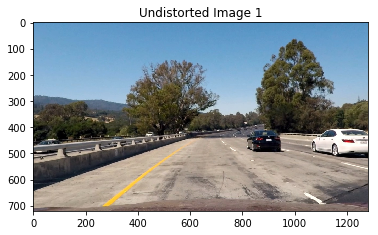

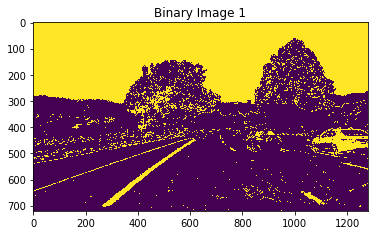

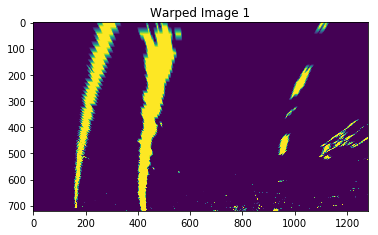

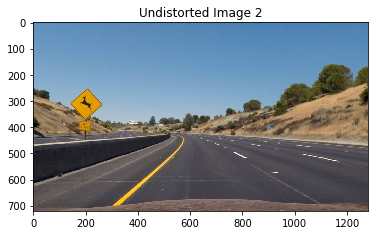

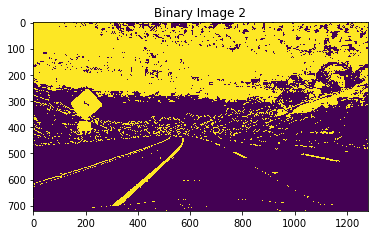

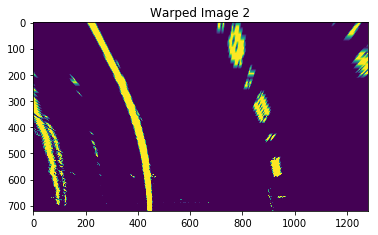

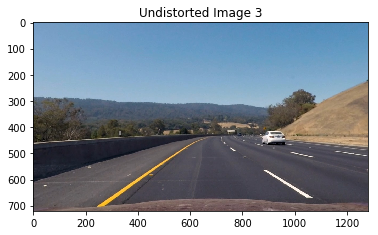

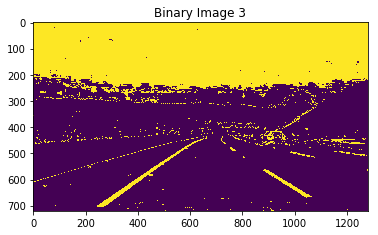

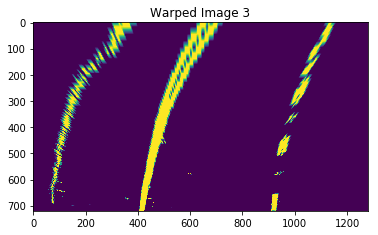

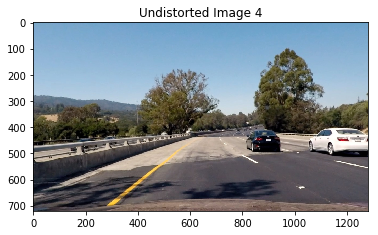

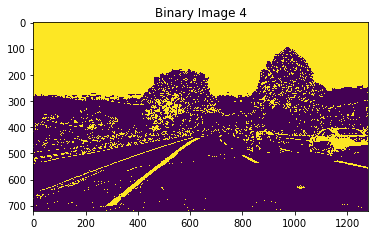

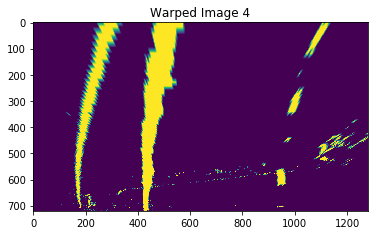

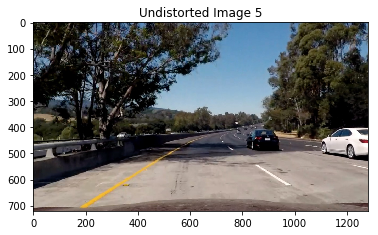

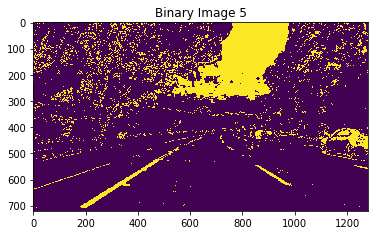

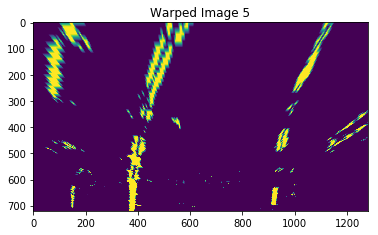

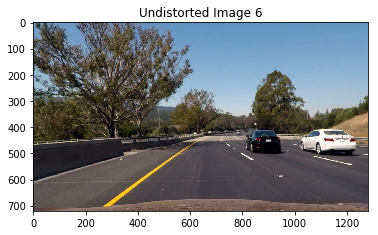

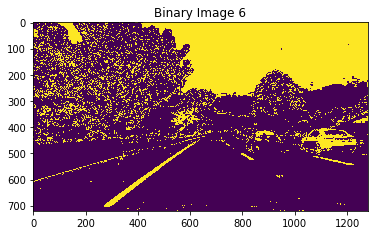

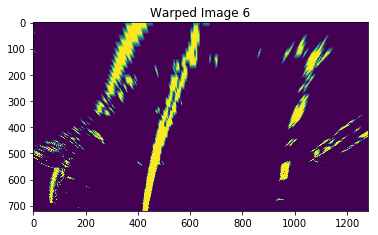

In [7]:
# Reads in the saved camera matrix and distortion coefficients
dist_pickle = pickle.load(open('./camera_cal/calibration_pickle.p', 'rb'))
mtx = dist_pickle["mtx"]
dist = dist_pickle["dist"]

# Make a list of test images
images = glob.glob('./test_images/*.jpg') 

for idx, fname in enumerate(images):
    
    # Reads in images
    img = cv2.imread(fname)
    
    # Changes colorspace to RGB
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    # Undistorts the image
    img = cv2.undistort(img, mtx, dist, None, mtx)
    
    # Proceses image and generats binary pixel of intrest
    preprocessImage = np.zeros_like(img[:,:,0]) # same size as original image
    gradx = abs_sobel_thresh(img, orient='x', thresh=(12, 255)) #12
    grady = abs_sobel_thresh(img, orient='y', thresh=(25, 255)) #25
    c_binary = color_threshold(img, sthresh=(100,255), vthresh=(50,255))
    preprocessImage[((gradx == 1) & (grady == 1) | (c_binary == 1))] = 255

    # Defins perspective transformation area (lane)
    img_size = (img.shape[1], img.shape[0])
    
    # Builds trapizoid
    upper_width = 0.08 # 0.08 # percent of  trapizoid height
    height = 0.62 # 0.62 percent for trapizoid height # how fare you are looking down the road
    lower_width = 0.76 # 0.76 # percent of bottom trapizoid height
    bottom_trim = 0.935 # 0.935 # percent from top to bottom to avoid car hood

    # Picks for source points
    src = np.float32([[img.shape[1]*(0.5-upper_width/2), img.shape[0]*height],
                      [img.shape[1]*(0.5+upper_width/2), img.shape[0]*height],
                      [img.shape[1]*(0.5+lower_width/2), img.shape[0]*bottom_trim],
                      [img.shape[1]*(0.5-lower_width/2), img.shape[0]*bottom_trim]
                     ])
    
    # Picks for destination points and offset
    offset = img_size[0] * 0.25
    dst = np.float32([[offset, 0],
                      [img_size[0] - offset, 0],
                      [img_size[0] - offset, img_size[1]],
                      [offset, img_size[1]]
                     ])
    
    # Prints the source and destination points
    #print("Source Points")
    #print(src)
    
    #print("Destination Points")
    #print(dst)    

    # Calculates transformation matrix M (and its inverse for later use)
    M = cv2.getPerspectiveTransform(src, dst)
    Minv = cv2.getPerspectiveTransform(dst, src)
    
    # Performs transformation
    warped = cv2.warpPerspective(preprocessImage, M, img_size, flags = cv2.INTER_LINEAR)
    
    # Plots the images
    plt.title('Undistorted Image ' + str(idx + 1))
    plt.imshow(img)

    plt.show()
    
    plt.title('Binary Image ' + str(idx + 1))
    plt.imshow(preprocessImage)

    plt.show()
    
    plt.title('Warped Image ' + str(idx + 1))
    plt.imshow(warped)

    plt.show()
    
    # Saves warped images
    write_name = './output_images/binary/' + str(idx) + '.jpg'
    cv2.imwrite(write_name, preprocessImage)
    
    write_name = './output_images/warped/' + str(idx) + '.jpg'
    cv2.imwrite(write_name, warped)

## Detect lane pixels and fit to find the lane boundary.

In [8]:
# Defines tracker
class tracker():
    
    # Sets up a search window for lane lines
    def __init__(self, Mywindow_width, Mywindow_height, Mymargin, My_xm=1, My_ym=1, Mysmooth_factor=15):
        
        # Stores all the past (left, right) center values used for smoothing the output
        self.recent_centers = []
        
        # Search window width of the center values in pixel
        self.window_width = Mywindow_width
        
        # Search window height of center values in pixel
        self.window_height = Mywindow_height

        # Sliding range of search window
        self.margin = Mymargin
        
        # Factors pixel in meters
        self.xm_per_pix = My_xm # meters per pixel in horizontal axis
        self.ym_per_pix = My_ym # meters per pixel in verical axis
        
        # Smoothing
        self.smooth_factor = Mysmooth_factor
        
    # Finds and stores lane segment positions
    def find_window_centroids (self, warped):
        
        # gets parameters
        window_width = self.window_width
        window_height = self.window_height
        margin = self.margin

        # Stores the (left, right) window centroids position per level
        window_centroids = [] 
        
        # Creates a search window template
        window = np.ones(window_width) 

        # Finds the two starting position for the left and right lane line
        # Gets the vertical image slice and convolves the vertical image slice
        l_sum = np.sum(warped[int(3 * warped.shape[0] / 4): , : int(warped.shape[1] / 2)], axis=0)
        l_center = np.argmax(np.convolve(window, l_sum)) - window_width/2
        r_sum = np.sum(warped[int(3 * warped.shape[0]/4) : , int(warped.shape[1] / 2) : ], axis=0)
        r_center = np.argmax(np.convolve(window, r_sum)) - window_width/2 + int(warped.shape[1] / 2)

        # Adds centers of the first layer to centroids list
        window_centroids.append((l_center, r_center))

        # Loops through the layers and searches for maximum pixel location (the layers centroids)
        for level in range(1,(int)(warped.shape[0]/window_height)):

            # Convolves the window into the vertical slice of the image
            image_layer = np.sum(warped[int(warped.shape[0]-(level+1)*window_height):int(warped.shape[0]-level*window_height),:], axis=0)
            conv_signal = np.convolve(window, image_layer)

            offset = window_width/2

            # Padds the convolution signal left lane marking
            l_min_index = int(max(l_center + offset - margin, 0))
            l_max_index = int(min(l_center + offset + margin, warped.shape[1]))

            # Finds the left centroid by using past left center as a reference
            l_center = np.argmax(conv_signal[l_min_index : l_max_index]) + l_min_index - offset

            # Padds the convolution signal right lane marking
            r_min_index = int(max(r_center + offset - margin, 0))
            r_max_index = int(min(r_center + offset + margin, warped.shape[1]))

            # Find the best right centroid by using past right center as a Reference       
            r_center = np.argmax(conv_signal[r_min_index:r_max_index]) + r_min_index - offset

            # Adds the centers to the centroid list
            window_centroids.append((l_center, r_center))

        self.recent_centers.append(window_centroids)

        # Returns average values of the line centers, smoothes the markers
        return np.average(self.recent_centers[-self.smooth_factor:], axis = 0)

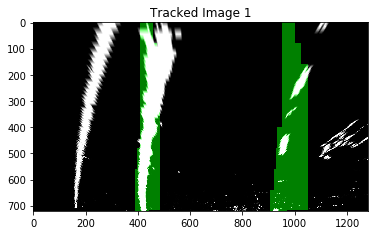

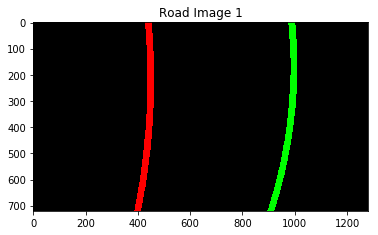

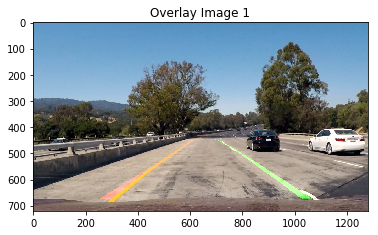

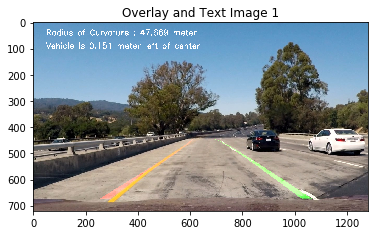

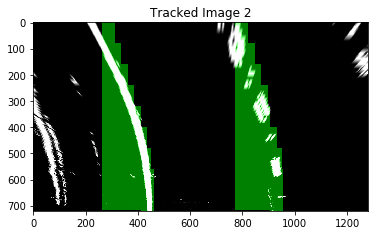

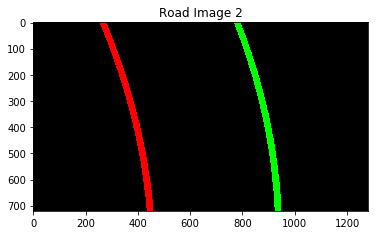

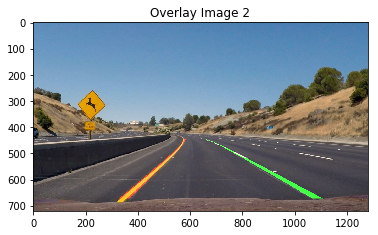

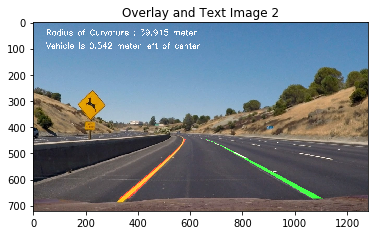

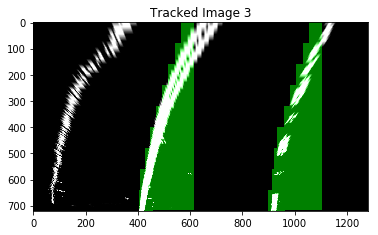

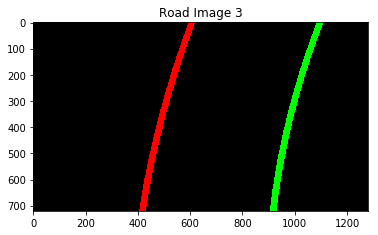

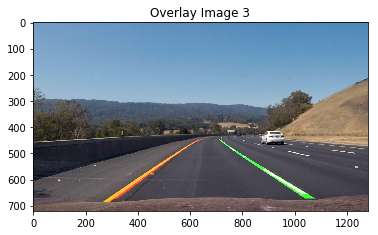

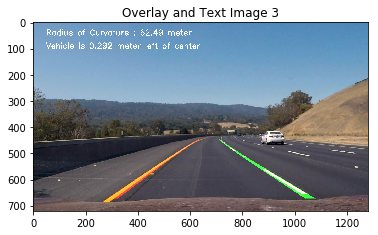

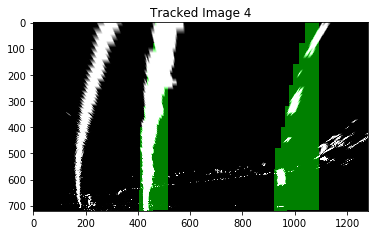

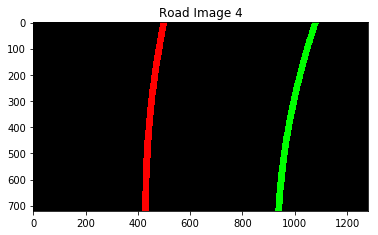

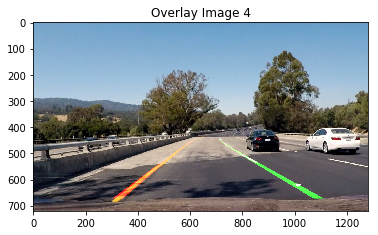

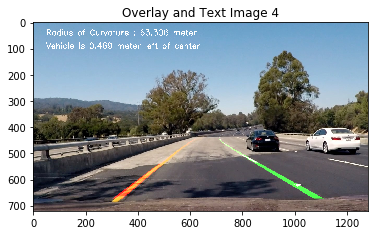

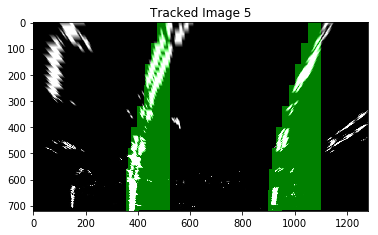

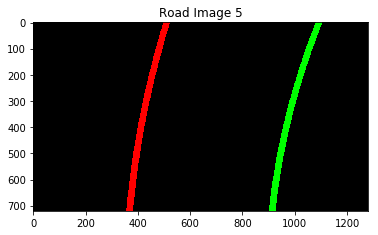

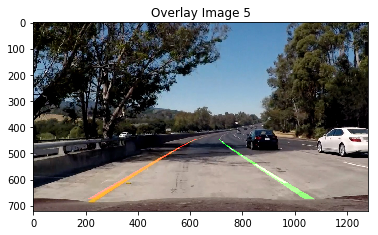

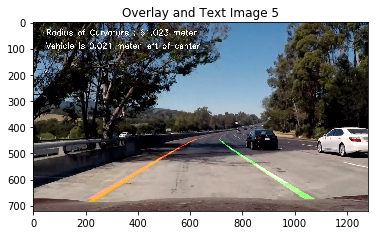

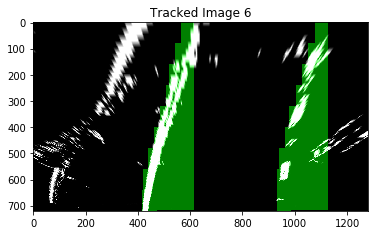

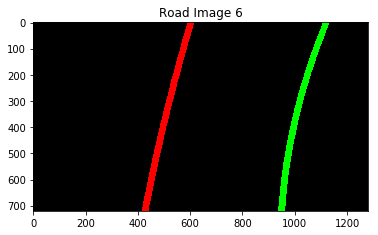

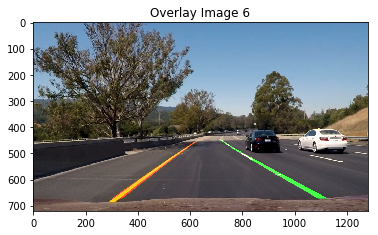

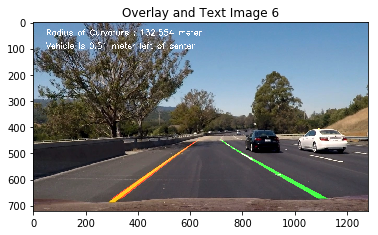

Finished


In [9]:
# Draws a box for a search window
def window_mask(width, hight, img_ref, center, level):
    
    # Prepares a binary output template
    output = np.zeros_like(img_ref)
    
    # Creats binary output mask
    output[int(img_ref.shape[0]-(level+1)*hight):int(img_ref.shape[0]-level*height), max(0,int(center-width)) : min(int(center+width), img_ref.shape[1])] = 1
    
    return output
    
# Loads warped images
warped_images = glob.glob('./output_images/warped/*.jpg')

# Step through the image list
for idx, fname in enumerate(warped_images):
    
    # Fetch the image
    warped = cv2.imread(fname)
    warped_gray = cv2.cvtColor(warped, cv2.COLOR_BGR2GRAY)
    
    # Sets the size of the search window
    window_width = 25
    window_height = 80
    
    # Sets up a tracker instance
    curve_centers = tracker(Mywindow_width = window_width, Mywindow_height = window_height, Mymargin = 25, My_xm = 4/384, My_ym = 10/720, Mysmooth_factor = 15)
    
    # Finds curve centers
    window_centroids = curve_centers.find_window_centroids(warped_gray)
    
    # Creats template for pionts used to draw the boxes
    l_points = np.zeros_like(warped_gray)
    r_points = np.zeros_like(warped_gray)

    # Records the x-values for left/right lane
    leftx = []
    rightx = []

    # Goes through each level and draws the boxes
    for level in range(0, len(window_centroids)):
        
        # Adds the x-values for left/right lane
        leftx.append(window_centroids[level][0])
        rightx.append(window_centroids[level][1])
        
        # Creates boxes
        l_mask = window_mask(window_width, window_height, warped_gray, window_centroids[level][0], level)
        r_mask = window_mask(window_width, window_height, warped_gray, window_centroids[level][1], level)
        
        # Adds graphic points from window mask to pixels found
        l_points[(l_points == 255) | ((l_mask == 1))] = 255
        r_points[(r_points == 255) | ((r_mask == 1))] = 255
    
# Draw the results

    # Adds both left and right window pixels together
    template = np.array(l_points + r_points, np.uint8)
    
    # Creats a zero color channel
    zero_channel = np.zeros_like(template)
    
    # Makes window pixels geen
    template = np.array(cv2.merge((zero_channel, template, zero_channel)), np.uint8) 
    
    # Makes the original road pixels 3 color channels
    warpage = np.array(cv2.merge((warped_gray,warped_gray,warped_gray)), np.uint8)
    
    # Overlays the original road image with window results
    tracked = cv2.addWeighted(warpage, 1, template, 0.5, 0.0)
    
    # Plots the images
    plt.title('Tracked Image ' + str(idx + 1))
    plt.imshow(tracked)
    plt.show()
    
    # Saves tracked images
    write_name = './output_images/tracked/' + str(idx) + '.jpg'
    cv2.imwrite(write_name, tracked)
    
# Creats lane lines and put them into the image
    
    # Creats template for the lanes
    yvals = range(0, tracked.shape[0])
    
    # Calculates the y-values of the points to fit the lane lines
    res_yvals = np.arange(tracked.shape[0] - (window_height/2), 0, -window_height)
    
    # Adds x-values and fits a polynomial through the resulting points
    left_poly = np.polyfit(res_yvals, leftx, 2)

    # Creats the values for left line from polynomial coefficients
    left_fitx = left_poly[0] * yvals * yvals + left_poly[1] * yvals + left_poly[2]
    left_fitx = np.array(left_fitx, np.int32)

    # Adds x-values and fits a polynomial through the resulting points
    right_poly = np.polyfit(res_yvals, rightx, 2)

    # Creats the values for right line from polynomial coefficients
    right_fitx = right_poly[0] * yvals * yvals + right_poly[1] * yvals + right_poly[2]
    right_fitx = np.array(right_fitx, np.int32)

    left_lane = np.array(list(zip(np.concatenate((left_fitx - window_width/2, left_fitx[::-1] + window_width/2), axis = 0), np.concatenate((yvals, yvals[::-1]), axis = 0))), np.int32)
    right_lane = np.array(list(zip(np.concatenate((right_fitx - window_width/2, right_fitx [::-1] + window_width/2), axis = 0), np.concatenate((yvals, yvals[::-1]), axis = 0))), np.int32)
    middle_marker = np.array(list(zip(np.concatenate((right_fitx - window_width/2, right_fitx[::-1] + window_width/2), axis = 0), np.concatenate((yvals, yvals[::-1]), axis = 0))), np.int32)

    # Creats a template for the road
    road = np.zeros_like(warped)

    # Colors the lane lines
    cv2.fillPoly(road, [left_lane], color = [255, 0, 0])
    cv2.fillPoly(road, [right_lane], color = [0, 255, 0])
    
    # Plots the images
    plt.title('Road Image ' + str(idx + 1))
    plt.imshow(road)
    plt.show()
    
    # Saves tracked images
    write_name = './output_images/road/' + str(idx) + '.jpg'
    cv2.imwrite(write_name, road)
    
    'Warp the detected lane boundaries back onto the original image.'
    
    # Warps the lines into object space
    road_warped = cv2.warpPerspective(road, Minv, img_size, flags = cv2.INTER_LINEAR)
    
    # Reads in images
    img = mpimg.imread('output_images/test' + str(idx + 1) + '.jpg')
    
    # Overlays the warped lines on the original image
    overlay = cv2.addWeighted(img, 1.0, road_warped, 1.0, 0.0)

    # Plots the images
    plt.title('Overlay Image ' + str(idx + 1))
    plt.imshow(overlay)
    plt.show()
    
    'Determine the curvature of the lane and vehicle position with respect to center.'

    # Defines meter object space in pixels
    ym_per_pix = curve_centers.ym_per_pix
    xm_per_pix = curve_centers.xm_per_pix
    
    # Fits polynomial to left lane line in meters
    curve_fit = np.polyfit(np.array(res_yvals, np.float32) * ym_per_pix, np.array(leftx, np.float32) * xm_per_pix, 2)
    
    # Returnes curve radius in meter of left line
    curverad = ((1 + (2 * curve_fit[0] * yvals[-1] * ym_per_pix + curve_fit[1]) **2) **1.5) / np.absolute(2*curve_fit[0])
    
    # Calculates the offset of the car on the road
    camera_center = (left_fitx[-1] + right_fitx[-1]) / 2
    center_diff = (camera_center - warped.shape[1] / 2) * xm_per_pix
    
    side_pos = 'left'
    if center_diff <= 0:
        side_pos = 'right'

    'Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.'
    # Draws the text showing curvature, offset, and speed
    cv2.putText(overlay, 'Radius of Curvature : ' + str(round(curverad, 3)) + ' meter', (50,50), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2)
    cv2.putText(overlay, 'Vehicle is ' + str(abs(round (center_diff, 3))) + ' meter ' + side_pos + ' of center', (50,100), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2)
    
    # Plots the images
    plt.title('Overlay and Text Image ' + str(idx + 1))
    plt.imshow(overlay)
    plt.show()
    
    # Saves overlayed images
    overlay = cv2. cvtColor(overlay, cv2.COLOR_BGR2RGB)
    write_name = './output_images/overlay/' + str(idx) + '.jpg'
    cv2.imwrite(write_name, overlay)
    
print('Finished')

In [10]:
# Reads in the saved camera matrix and distortion coefficients
dist_pickle = pickle.load(open('./camera_cal/calibration_pickle.p', 'rb'))
mtx = dist_pickle["mtx"]
dist = dist_pickle["dist"]


def process_image(img):

# Preprocesses the image

    # Undistorts the image
    img = cv2.undistort(img, mtx, dist, None, mtx)
    
    # Proceses image and generats binary pixel of intrest
    preprocessImage = np.zeros_like(img[:,:,0]) # same size as original image
    gradx = abs_sobel_thresh(img, orient='x', thresh=(12, 255)) #12
    grady = abs_sobel_thresh(img, orient='y', thresh=(25, 255)) #25
    c_binary = color_threshold(img, sthresh=(100,255), vthresh=(50,255))
    preprocessImage[((gradx == 1) & (grady == 1) | (c_binary == 1))] = 255

# Warps the image

    # Defins perspective transformation area (lane)
    img_size = (img.shape[1], img.shape[0])
    
    # Builds trapizoid
    upper_width = 0.08 # 0.08
    height = 0.62 # 0.62 percent for trapizoid height # how fare you are looking down the road
    lower_width = 0.76 # 0.76 
    bottom_trim = 0.935 # 0.935 # percent from top to bottom to avoid car hood

    # Picks for source points
    src = np.float32([[img.shape[1]*(0.5-upper_width/2), img.shape[0]*height],
                      [img.shape[1]*(0.5+upper_width/2), img.shape[0]*height],
                      [img.shape[1]*(0.5+lower_width/2), img.shape[0]*bottom_trim],
                      [img.shape[1]*(0.5-lower_width/2), img.shape[0]*bottom_trim]
                     ])
    
    # Picks for destination points and offset
    offset = img_size[0] * 0.2
    dst = np.float32([[offset, 0],
                      [img_size[0] - offset, 0],
                      [img_size[0] - offset, img_size[1]],
                      [offset, img_size[1]]
                     ])

    # Calculates transformation matrix M (and its inverse for later use)
    M = cv2.getPerspectiveTransform(src, dst)
    Minv = cv2.getPerspectiveTransform(dst, src)
    
    # Performs transformation
    warped = cv2.warpPerspective(preprocessImage, M, img_size, flags = cv2.INTER_LINEAR)

# Finds Centroids

    # Sets the size of the search window
    window_width = 25
    window_height = 80
    
    # Sets up a tracker instance
    curve_centers = tracker(Mywindow_width = window_width, Mywindow_height = window_height, Mymargin = 25, My_xm = 4/384, My_ym = 10/720, Mysmooth_factor = 15)

    # Finds curve centers
    window_centroids = curve_centers.find_window_centroids(warped)

    # Records the x-values for left/right lane
    leftx = []
    rightx = []

    # Goes through each level and draws the boxes
    for level in range(0, len(window_centroids)):
        
        # Adds the x-values for left/right lane
        leftx.append(window_centroids[level][0])
        rightx.append(window_centroids[level][1])
    
# Creats lane lines and put them into the image
    
    # Creats template for the lanes
    yvals = range(0, tracked.shape[0])
    
    # Calculates the y-values of the points to fit the lane lines
    res_yvals = np.arange(tracked.shape[0] - (window_height/2), 0, - window_height)
    
    # Adds x-values and fits a polynomial through the resulting points
    left_poly = np.polyfit(res_yvals, leftx, 2)

    # Creats the values for left line from polynomial coefficients
    left_fitx = left_poly[0] * yvals * yvals + left_poly[1] * yvals + left_poly[2]
    left_fitx = np.array(left_fitx, np.int32)

    # Adds x-values and fits a polynomial through the resulting points
    right_poly = np.polyfit(res_yvals, rightx, 2)

    # Creats the values for right line from polynomial coefficients
    right_fitx = right_poly[0] * yvals * yvals + right_poly[1] * yvals + right_poly[2]
    right_fitx = np.array(right_fitx, np.int32)
    
    # Creats lane pixel arrays
    left_lane     = np.array(list(zip(np.concatenate((left_fitx - window_width/2, left_fitx[::-1] + window_width/2), axis = 0), np.concatenate((yvals, yvals[::-1]), axis = 0))), np.int32)
    middle_marker = np.array(list(zip(np.concatenate((left_fitx + window_width/2, right_fitx [::-1] - window_width/2), axis = 0), np.concatenate((yvals, yvals[::-1]), axis = 0))), np.int32)
    right_lane    = np.array(list(zip(np.concatenate((right_fitx - window_width/2, right_fitx [::-1] + window_width/2), axis = 0), np.concatenate((yvals, yvals[::-1]), axis = 0))), np.int32)
    
    # Creats a templates for the road
    road = np.zeros_like(img)

    # Colors the lines
    cv2.fillPoly(road, [left_lane], color = [255, 0, 0]) #red
    cv2.fillPoly(road, [right_lane], color = [0, 255, 0]) #green
    cv2.fillPoly(road, [middle_marker], color = [0, 0, 255]) #blue

    # Warps the lines into object space
    road_warped = cv2.warpPerspective(road, Minv, img_size, flags = cv2.INTER_LINEAR)

    # Overlays the warped lines on the original image
    overlay = cv2.addWeighted(img, 1.0, road_warped, 0.7, 0.0)

# Calculates of curvature

    # Defines meter object space in pixels
    xm_per_pix = curve_centers.xm_per_pix
    ym_per_pix = curve_centers.ym_per_pix
    

    # Fits polynomial to left lane line in meters
    curve_fit = np.polyfit(np.array(res_yvals, np.float32) * ym_per_pix, np.array(leftx, np.float32) * xm_per_pix, 2)
    
    # Returnes curve radius in meter of left line
    curverad = ((1 + (2 * curve_fit[0] * yvals[-1] * ym_per_pix + curve_fit[1]) **2) **1.5) / np.absolute(2*curve_fit[0])
    
    # Calculates the offset of the car on the road
    camera_center = (left_fitx[-1] + right_fitx[-1]) / 2
    center_diff = (camera_center - warped.shape[1] / 2) * xm_per_pix
    
    side_pos = 'left'
    if center_diff <= 0:
        side_pos = 'right'

    # Draws the text showing curvature, offset, and speed
    cv2.putText(overlay, 'Radius of Curvature : ' + str(round(curverad, 3)) + ' meter', (50,50), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2)
    cv2.putText(overlay, 'Vehicle is ' + str(abs(round (center_diff, 3))) + ' meter ' + side_pos + ' of center', (50,100), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2)
     
    return overlay


In [11]:
# Defines I/O

input_video = 'project_video.mp4'
output_video = 'output_tracked.mp4'

# Processes Video
clip = VideoFileClip(input_video)
video_clip = clip.fl_image(process_image) # colored images
%time video_clip.write_videofile(output_video, audio=False)

[MoviePy] >>>> Building video output_tracked.mp4
[MoviePy] Writing video output_tracked.mp4


100%|█████████▉| 1260/1261 [03:38<00:00,  5.28it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: output_tracked.mp4 

CPU times: user 4min 10s, sys: 30.9 s, total: 4min 41s
Wall time: 3min 39s


In [12]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(output_video))